<a id='top'></a>
<img align="center" src="https://cdn.hswstatic.com/gif/online-harassment-7-orig.jpg" width="200" />
<p style="text-align: center;">
    <font size='5' type='bold'>
        <b>Определение токсичных комментариев</b>
    </font>
</p>

<a id='section_1'></a>
# Содержание

<a href='#section_1'>1 Содержание</a>

<a href='#section_2'>2 Описание проекта</a>

<a href='#section_3'>3 Подготовка</a>

<a href='#section_4'>4 Обучение</a>

<a href='#section_5'>5 Вывод</a>

<a href='#section_6'>6 Чек-лист готовности проекта</a>

<a id='section_2'></a>
# Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

<a href='#top'>Back to top</a>

<a id='section_3'></a>
# Подготовка

In [1]:
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

rnd_state = 260686

In [2]:
df = pd.read_csv('/datasets/toxic_comments.csv')
df.head(3)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Прежде чем извлечь признаки из текста, упростим его через лемматизацию.

In [4]:
def lemmatize(text):
    wn = nltk.WordNetLemmatizer()
    lemm_list = wn.lemmatize(text)
    lemm_text = "".join(lemm_list)
 
    return lemm_text

df['lemm_text'] = df['text'].apply(lambda x: lemmatize(x))
df.head(3)

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation\nWhy the edits made under my usern...
1,D'aww! He matches this background colour I'm s...,0,D'aww! He matches this background colour I'm s...
2,"Hey man, I'm really not trying to edit war. It...",0,"Hey man, I'm really not trying to edit war. It..."


От лишних символов текст очистят регулярные выражения.

In [5]:
def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z]', ' ', text)
    clear_text = " ".join(clear_text.split())
    return clear_text

df['clear_text'] = df['lemm_text'].apply(lambda x: clear_text(x))
df.head(3)

,text,toxic,lemm_text,clear_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation\nWhy the edits made under my usern...,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D'aww! He matches this background colour I'm s...,D aww He matches this background colour I m se...
2,"Hey man, I'm really not trying to edit war. It...",0,"Hey man, I'm really not trying to edit war. It...",Hey man I m really not trying to edit war It s...


<a href='#top'>Back to top</a>

<a id='section_4'></a>
# Обучение

Поделим наши данные на обучающую и тестовую выборки.

In [6]:
train, test = train_test_split(df, test_size=0.3, random_state=rnd_state)

Обучим логистическую регрессию так, чтобы она определяла токсичность комментариев. Подсчитаем величину TF-IDF для текстов. 
Обученной моделью классификации определим результаты предсказания.

In [7]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

X_train = train['clear_text'].astype('U')
y_train = train['toxic']
X_test = test['clear_text'].astype('U')
y_test = test['toxic']

tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf_train = tf_idf.fit_transform(X_train) 
tf_idf_test = tf_idf.transform(X_test)

model = LogisticRegression()
model.fit(tf_idf_train, y_train)
y_pred = pd.Series(model.predict(tf_idf_test))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


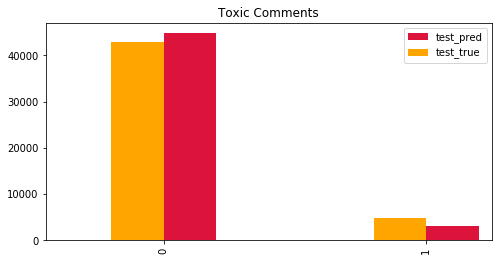

In [8]:
ax = plt.gca()
        
y_pred.value_counts().plot(kind='bar', figsize=(8,4), ax=ax, position=0, color='crimson', width=0.2)
y_test.value_counts().plot(kind='bar', figsize=(8,4), ax=ax, position=1, color='orange', width=0.2)

plt.title('Toxic Comments')
plt.legend(loc='upper right')

ax.legend(['test_pred', 'test_true'])

plt.show()

В целом модель работает хорошо, судя по графикам. Однако нам необходима модель со значением метрики качества F1 не меньше 0.75. Проверим значение F1 нашей текущей модели.

In [9]:
f1_score(y_test, y_pred)

0.7248154173445126

Попробуем улучшить результат настраивая гиперпараметр поиском по сетке.

In [10]:
%%time
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 1))),
    ('model', LogisticRegression(random_state=rnd_state, solver='liblinear', max_iter=500))
    ])

params = [
        {
            'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
            'model': [LogisticRegression(random_state=rnd_state, solver='liblinear')],
            'model__C': [10, 50]
        }
]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=rnd_state)
grid = GridSearchCV(pipe, param_grid=params, scoring='f1', cv=cv, verbose=10)

grid.fit(X_train, y_train)
grid.best_params_, grid.best_score_

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] model=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=260686, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False), model__C=10, vectorizer__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=260686, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False), model__C=10, vectorizer__ngram_range=(1, 1), score=0.773, total=  20.1s
[CV] model=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=260686, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False), model__C=10, vectorizer__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.1s remaining:    0.0s


[CV]  model=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=260686, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False), model__C=10, vectorizer__ngram_range=(1, 1), score=0.773, total=  19.9s
[CV] model=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=260686, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False), model__C=10, vectorizer__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   40.0s remaining:    0.0s


[CV]  model=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=260686, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False), model__C=10, vectorizer__ngram_range=(1, 1), score=0.776, total=  21.1s
[CV] model=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=260686, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False), model__C=10, vectorizer__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min remaining:    0.0s


[CV]  model=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=260686, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False), model__C=10, vectorizer__ngram_range=(1, 2), score=0.757, total=  41.1s
[CV] model=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=260686, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False), model__C=10, vectorizer__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.7min remaining:    0.0s


[CV]  model=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=260686, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False), model__C=10, vectorizer__ngram_range=(1, 2), score=0.749, total=  38.0s
[CV] model=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=260686, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False), model__C=10, vectorizer__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.3min remaining:    0.0s


[CV]  model=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=260686, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False), model__C=10, vectorizer__ngram_range=(1, 2), score=0.749, total=  41.5s
[CV] model=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=260686, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False), model__C=10, vectorizer__ngram_range=(2, 2) 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  3.0min remaining:    0.0s


[CV]  model=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=260686, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False), model__C=10, vectorizer__ngram_range=(2, 2), score=0.561, total=  33.1s
[CV] model=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=260686, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False), model__C=10, vectorizer__ngram_range=(2, 2) 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.6min remaining:    0.0s


[CV]  model=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=260686, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False), model__C=10, vectorizer__ngram_range=(2, 2), score=0.571, total=  33.6s
[CV] model=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=260686, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False), model__C=10, vectorizer__ngram_range=(2, 2) 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  4.2min remaining:    0.0s


[CV]  model=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=260686, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False), model__C=10, vectorizer__ngram_range=(2, 2), score=0.565, total=  33.4s
[CV] model=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=260686, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False), model__C=50, vectorizer__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  4.7min remaining:    0.0s


[CV]  model=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=260686, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False), model__C=50, vectorizer__ngram_range=(1, 1), score=0.772, total=  27.6s
[CV] model=LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=260686, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False), model__C=50, vectorizer__ngram_range=(1, 1) 
[CV]  model=LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', 

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 10.4min finished


CPU times: user 8min 16s, sys: 2min 38s, total: 10min 55s
Wall time: 10min 55s


({'model': LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=260686, solver='liblinear', tol=0.0001,
                     verbose=0, warm_start=False),
  'model__C': 50,
  'vectorizer__ngram_range': (1, 1)},
 0.7765048871405252)

In [13]:
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1_score(y_test, y_pred)

0.7762198541783512

<a href='#top'>Back to top</a>

<a id='section_5'></a>
# Вывод

* Модель логистической регрессии с оптимизированными параметрами отлично работает и показывает необходимый результат по значению F1-меры - выше 0.75

<a href='#top'>Back to top</a>